In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
# Change these 
training_data_dir = "../datasets/training_data/data"
split_dir = "../datasets/training_data/splits"

In [5]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [6]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')

In [7]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

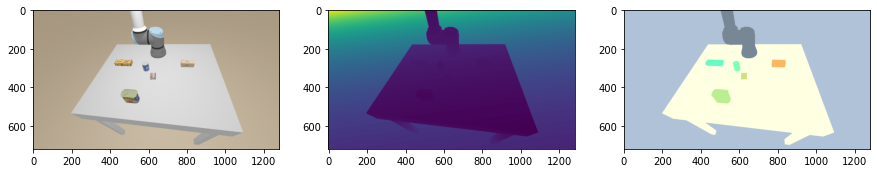

In [8]:
import numpy as np
rgb = np.array(Image.open(rgb_files[10])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[10])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[10]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [11]:
sel_dep = depth[label==35]
np.max(sel_dep) - np.min(sel_dep)
len(sel_dep)

2873

In [13]:
import torch
a=torch.arange(3)
ind = torch.tensor([2, 0, 1]).long()
mask = torch.tensor(2)
a[ind[:mask]] = 3
a

tensor([3, 1, 3])

In [ ]:
meta = load_pickle(meta_files[10])
meta.keys()

dict_keys(['intrinsic'])

## Lift depth to point cloud

In [ ]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]

In [ ]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud